In [54]:
import sys
!{sys.executable} -m pip install contractions
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2

!pip install spacy
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



⚙️ **Requerimientos importantes sobre el ejercicio**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.



## Imports

In [55]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
# Add your imports here
import pandas as pd

# 🔍 Ejercicio1: Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

📝 **Criterios de Evaluación**

Tu trabajo será evaluado según los siguientes criterios:

| Criterio                                            | Peso  |
|-----------------------------------------------------|--------|
| 🔍 Análisis exploratorio y preprocesamiento         | 20%   |
| 🤖 Selección y justificación del modelo             | 25%   |
| 📁 Formato y validez del archivo de predicciones    | 5%    |
| ⚙️ Ejecución correcta del notebook (sin intervención) | 10%   |
| 📈 Rendimiento del modelo sobre el conjunto de test | 30%   |
| ✍️ Claridad y calidad de las explicaciones          | 10%   |



🔔 **Nota importante:**

> El rendimiento del modelo se evaluará utilizando métricas estándar como el **F1-score** sobre el conjunto de test.

> El archivo de predicciones debe respetar **estrictamente** el formato solicitado (`id` y `label`, separados por tabulador y con extensión `.tsv`).  
  ❗ Si el archivo no cumple con este formato, **el ejercicio no podrá ser evaluado en esa sección**.

> El/la estudiante con el **mayor F1-score** obtendrá la puntuación máxima en el apartado de rendimiento. El resto de calificaciones se ajustarán de forma proporcional al mejor resultado



⚙️ **Requerimientos y reglas**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.


# Tu resolución (rellena las celdas marcadas)

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [57]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [58]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [59]:
dataset_train_df.to_csv('train.csv', index=False)
dataset_val_df.head()
# dataset_test_df.head()
#dataset_train_df[dataset_train_df['tweet_id'] == '1289869622187945984']

,tweet_id,text,label
0,1289869622187945984,Entró a trabajar a una residencia de ancianos ...,1
1,1247996977587109888,"600 muertos después , Suecia mantiene su estra...",0
2,1253019627183104000,@AUGC_Comunica Sra. Directora @guardiacivil @M...,1
3,1251069108629749762,"Se me ocurrió de repente , al ver la poca tras...",1
4,1262400218227789825,".@AlmeidaPP _ , ese miserable que no se mereci...",0


In [60]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
  num_docs = len(dataset_df)

  # Si se quiere obtener únicamente los que tienen textos distintos de vacío
  # num_docs = len(dataset_df[~dataset_df['text'].isna()])

  # No modifiques el return
  return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [61]:
# Aplica la función
print(f"El numero de documentos en TRAIN son: {get_num_docs_evaluation(dataset_train_df)}")
print(f"El numero de documentos en VALIDATION son: {get_num_docs_evaluation(dataset_val_df)}")


El numero de documentos en TRAIN son: 2786
El numero de documentos en VALIDATION son: 999


**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [62]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.

  num_duplicates = dataset_df.duplicated(subset='text').sum()
  # No modifiques el return
  return num_duplicates

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [63]:
# Aplica la función
print(f"El número de documentos duplicados en TRAIN son: {detect_duplicates_evaluation(dataset_train_df)}")
print(f"El número de documentos duplicados en VALIDATION son: {detect_duplicates_evaluation(dataset_val_df)}")

El número de documentos duplicados en TRAIN son: 0
El número de documentos duplicados en VALIDATION son: 0


**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [64]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = len(dataset_df[dataset_df['label'] == 1])
  num_negatives = len(dataset_df[dataset_df['label'] == 0])

  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [85]:
# Aplica la función
num_train_positives, num_train_negatives = analyse_num_labels_evaluation(dataset_train_df)
num_val_positives, num_val_negatives = analyse_num_labels_evaluation(dataset_val_df)

print(f"El número de documentos en TRAIN que son positivos son: {num_train_positives} y negativos son: {num_train_negatives}")
print(f"El número de documentos en VALIDATION que son positivos son: {num_val_positives} y negativos son: {num_val_negatives}")


El número de documentos en TRAIN que son positivos son: 1393 y negativos son: 1393
El número de documentos en VALIDATION que son positivos son: 238 y negativos son: 761


**Distribución de la longitud de los tweet en caracteres:**

<Figure size 1400x1200 with 0 Axes>

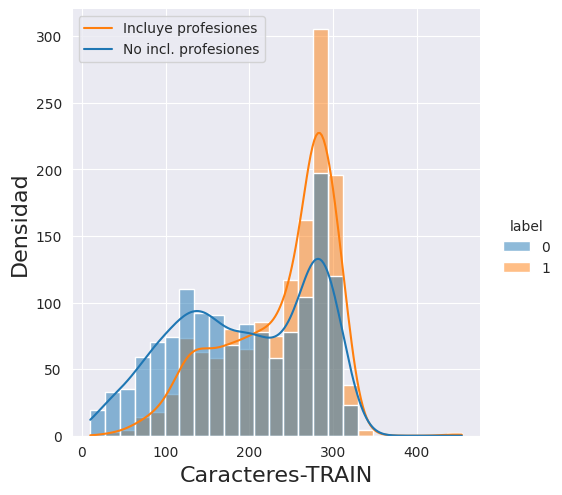

In [86]:
dataset_train_df['char_len'] = dataset_train_df['text'].apply(lambda x: len(x))

# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset_train_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["Incluye profesiones", "No incl. profesiones"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres-TRAIN', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

In [67]:
dataset_train_df.describe()

,label,char_len
count,2786.00000,2786.000000
mean,0.50000,215.057430
std,0.50009,77.171112
min,0.00000,10.000000
25%,0.00000,152.000000
50%,0.50000,235.000000
75%,1.00000,282.000000
max,1.00000,454.000000


<Figure size 1400x1200 with 0 Axes>

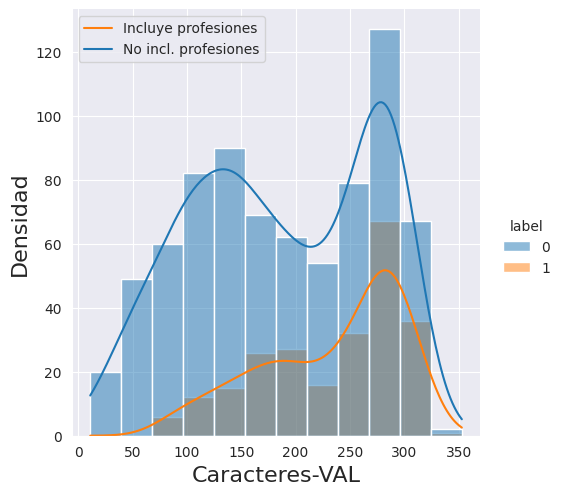

In [87]:
dataset_val_df['char_len'] = dataset_val_df['text'].apply(lambda x: len(x))

# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset_val_df, x="char_len", hue="label", kde=True, legend=True)
plt.legend(["Incluye profesiones", "No incl. profesiones"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres-VAL', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

In [88]:
dataset_val_df.describe()

,label,char_len
count,999.000000,999.000000
mean,0.238238,198.391391
std,0.426219,81.782717
min,0.000000,11.000000
25%,0.000000,132.500000
50%,0.000000,204.000000
75%,0.000000,277.000000
max,1.000000,353.000000


**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

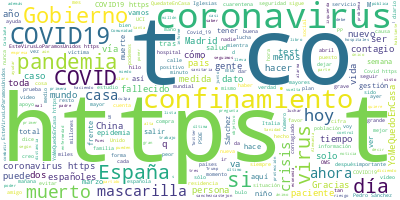

In [68]:
from wordcloud import WordCloud
txt_cat0 = ",".join(dataset_train_df[dataset_train_df['label'] == 0]['text'].to_list())
txt_cat1 = ",".join(dataset_train_df[dataset_train_df['label'] == 1]['text'].to_list())

from nltk.corpus import stopwords
es_stopwords = set(stopwords.words('spanish'))

wordcloud = WordCloud(background_color='white',
                      max_words=5000,
                      contour_width=0,
                      contour_color='plasma',
                      stopwords=es_stopwords,
                      normalize_plurals=True)

wordcloud.generate(txt_cat0)
wordcloud.to_image()

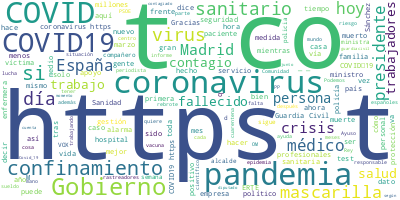

In [69]:
wordcloud.generate(txt_cat1)
wordcloud.to_image()

## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [70]:
# IMPORTS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()

Selecciona un modelo apropiado para la tarea:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

In [71]:
#NO-MODIFY: VARIABLE NAME
model_name = 'BSC-NLP4BIA/prof-ner-es'

> El modelo BSC-NLP4BIA/prof-ner-es para token-classification está en idioma español, y esta basada o fue entretando en "MEDDOPROF corpus", indicando que es un: "complete gold standard annotations for occupation detection in medical documents in Spanish". Al ser un análisis de tweets relacionados con Covid, asumo que los profesionales de la medicina son los más proclives a ser mencionados.
Fuente:
https://huggingface.co/BSC-NLP4BIA/prof-ner-es
https://zenodo.org/records/7116201

Puedes continuar con el proceso aquí:

In [78]:
# Utilizando el procedimiento que vimos en clase
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

def replace_contraction(text):
  return contractions.fix(text, slang=True)

# Tokenizador
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

# Lematizar
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])
# es_core_news_md -> idioma español

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in es_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado


In [73]:
dataset_train_df['normalized'] = dataset_train_df['text'].progress_apply(lambda x: eliminar_espacios(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: texto_to_lower(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: replace_contraction(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: normalizar_tokens(x))
dataset_train_df['normalized'] = dataset_train_df['normalized'].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

In [84]:
dataset_train_df.info()

from transformers import AutoTokenizer
# model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
text = dataset_train_df[dataset_train_df['tweet_id'] == '1250125742144466954']['normalized'].iloc[0]
print(tokenizer.tokenize(text))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2786 entries, 0 to 2785
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    2786 non-null   object
 1   text        2786 non-null   object
 2   label       2786 non-null   int64 
 3   char_len    2786 non-null   int64 
 4   normalized  2786 non-null   object
dtypes: int64(2), object(3)
memory usage: 109.0+ KB
['ĠneurÃ³logo', 'Ġhospital', 'ĠclÃŃnico', 'Ġsan', 'Ġcar', 'los', 'Ġdedicado', 'Ġpaciente', 'Ġcovid', 'ĠN', 'UM', 'Ġpositivo', 'ĠM', 'ENT', 'ION', 'Ġprimero', 'ĠlÃŃnea', 'Ġsiempre', 'Ġrodeado', 'Ġesperanza', 'Ġmayor', 'Ġexperto', 'Ġcefaleas', 'Ġcierto', 'Ġsomos', 'todo', 'Ġsomos', 'ser', 'ma', 'Ġsomos', 'clin', 'ico', 'ĠURL']


## Fine-tuning

Carga el model para ser ajustado posteriormente:

### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [74]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
)

NameError: name 'TrainingArguments' is not defined

### Métricas de evaluación

Define las métricas de evaluación

### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

## Evaluacion

Una vez llevada a cabo el entrenamiento, realiza la evaluación del modelo.

## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.
